In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(train_img,train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

In [3]:
train_img =tf.cast(train_img,tf.float32)
train_img =train_img/127.5-1
train_img =np.expand_dims(train_img,-1)

In [4]:
dataset=tf.data.Dataset.from_tensor_slices((train_img,train_labels))

In [5]:
AUTOTUNE=tf.data.AUTOTUNE

In [6]:
dataset=dataset.shuffle(60000).batch(100).prefetch(AUTOTUNE)

In [7]:
noise_dim = 50

In [8]:
def generator():
    label = tf.keras.layers.Input(shape=(()))
    seed = tf.keras.layers.Input(shape=((noise_dim)))
    
    x = tf.keras.layers.Embedding(10,50,input_length=1)(label)
    x = tf.keras.layers.concatenate([seed,x])
    
    x = tf.keras.layers.Dense(3*3*128, use_bias=False)(x)
    x=  tf.keras.layers.Reshape((3,3,128))(x)
    
    x= tf.keras.layers.Conv2DTranspose(64,3,strides=2,use_bias=False)(x)                 #7*7*64
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.ReLU()(x)
    
    x= tf.keras.layers.Conv2DTranspose(32,3,strides=2,padding='same',use_bias=False)(x)  #14*14*32
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.ReLU()(x)                                  
    
    x= tf.keras.layers.Conv2DTranspose(1,3,strides=2,padding='same',use_bias=False)(x)   #28*28*1
    output=tf.keras.layers.Activation('tanh')(x)
    
    model=tf.keras.Model(inputs=[label,seed],outputs=output)
    return model
 

In [9]:
gen= generator()

In [10]:
gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50)           500         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 100)          0           input_2[0][0]                    
                                                                 embedding[0][0]              

In [12]:
def discriminator():
    img = tf.keras.layers.Input(shape=(28,28,1))
    
    
    x = tf.keras.layers.Conv2D(32,3,strides=2,padding='same',use_bias=False)(img)    #14*14*32
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Conv2D(64,3,strides=2,padding='same',use_bias=False)(x)    #7*7*64
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)    
    
    x = tf.keras.layers.Conv2D(128,3,strides=2,use_bias=False)(x)                   #3*3*128
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)   
    
    x = tf.keras.layers.Flatten()(x)
    ture_or_fake = tf.keras.layers.Dense(1)(x)
    class_out = tf.keras.layers.Dense(10)(x)
    
    model = tf.keras.Model(inputs=img,outputs=[ture_or_fake,class_out])
    return model

In [13]:
disc =discriminator()

In [32]:
disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   288         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 14, 14, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14, 14, 32)   0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [42]:
def disc_loss_fn(true_out,true_class_out,fake_out,true_label):
    true_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(true_out),true_out,from_logits=True)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_out),fake_out,from_logits=True)
    true_class_loss = tf.keras.losses.sparse_categorical_crossentropy(true_label,true_class_out,from_logits=True)
    disc_loss=true_loss+fake_loss+true_class_loss

    return disc_loss

In [43]:
def gen_loss_fn(fake_out,fake_class_out,fake_label):
    fake_class_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_label,fake_class_out,from_logits=True)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_out),fake_out,from_logits=True)
    gen_loss=fake_class_loss+fake_loss
    return gen_loss
    

In [44]:
opt_gen=tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_disc=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [45]:
@tf.function()
def train_step(image,label):
    seed=np.random.normal(size=(label.shape[0],noise_dim))
 
    
    with tf.GradientTape() as disc_t, tf.GradientTape() as gen_t:
        fake_img=gen((label,seed))
        (true_out,true_class_out)=disc(image)
        (fake_out,fake_class_out)=disc(fake_img)
        disc_loss=disc_loss_fn(true_out,true_class_out,fake_out,label)
        gen_loss=gen_loss_fn(fake_out,fake_class_out,label)
        
        d_grad = disc_t.gradient(disc_loss,disc.trainable_variables)
        g_grad = gen_t.gradient(gen_loss,gen.trainable_variables)
        opt_disc.apply_gradients(zip(d_grad,disc.trainable_variables))
        opt_gen.apply_gradients(zip(g_grad,gen.trainable_variables))
    
        
    
    

In [55]:
epochs = 500

In [56]:
label_plot = np.array([0,1,2,3,4,5,6,7,8,9])
label_plot.shape

(10,)

In [57]:
def plot_img():
    plt.figure(figsize=(10,10))
    seed_plot= np.random.normal(size=(10,noise_dim))
    imgs =gen([label_plot,seed_plot])
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

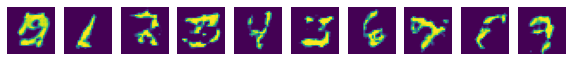

In [58]:
plot_img()

1,

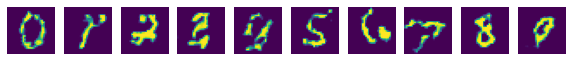

2,3,4,5,6,7,8,9,10,11,

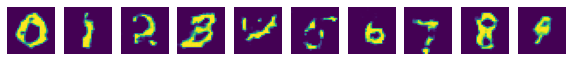

12,13,14,15,16,17,18,19,20,21,

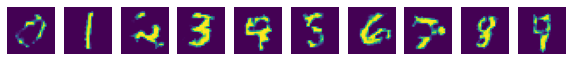

22,23,24,25,26,27,28,29,30,31,

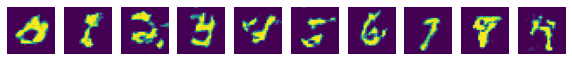

32,33,34,35,36,37,38,39,40,41,

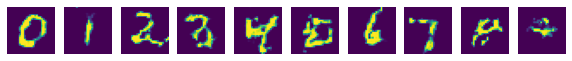

42,43,44,45,46,47,48,49,50,51,

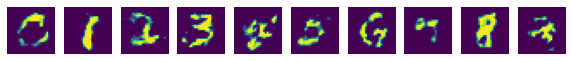

52,53,54,55,56,57,58,59,60,61,

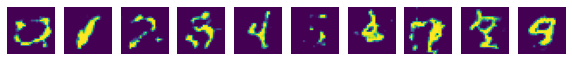

62,63,64,65,66,67,68,69,70,71,

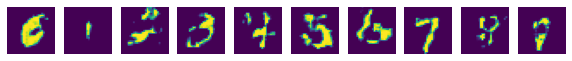

72,73,74,75,76,77,78,79,80,81,

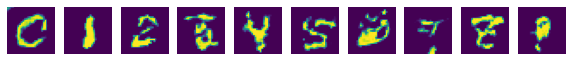

82,83,84,85,86,87,88,89,90,91,

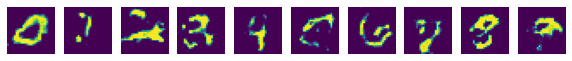

92,93,94,95,96,97,98,99,100,101,

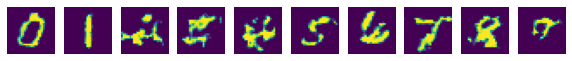

102,103,104,105,106,107,108,109,110,111,

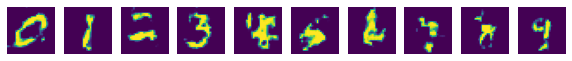

112,113,114,115,116,117,118,119,120,121,

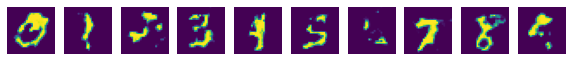

122,123,124,125,126,127,128,129,130,131,

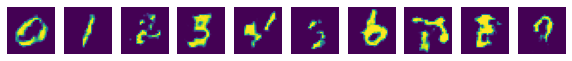

132,133,134,135,136,137,138,139,140,141,

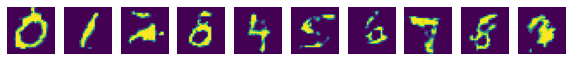

142,143,144,145,146,147,148,149,150,151,

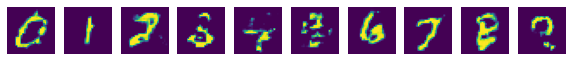

152,153,154,155,156,157,158,159,160,161,

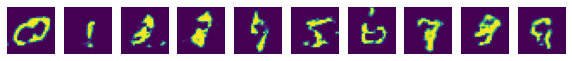

162,163,164,165,166,167,168,169,170,171,

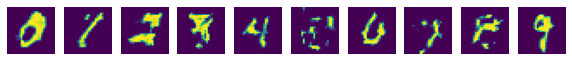

172,173,174,175,176,177,178,179,180,181,

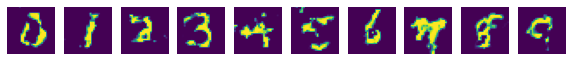

182,183,184,185,186,187,188,189,190,191,

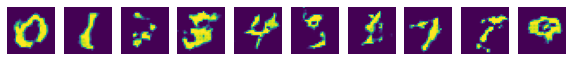

192,193,194,195,196,197,198,199,200,201,

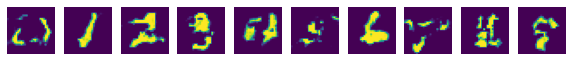

202,203,204,205,206,207,208,209,210,211,

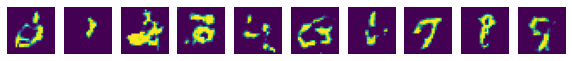

212,213,214,215,216,217,218,219,220,221,

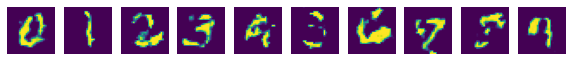

222,223,224,225,226,227,228,229,230,231,

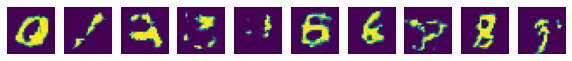

232,233,234,235,236,237,238,239,240,241,

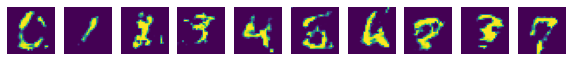

242,243,244,245,246,247,248,249,250,251,

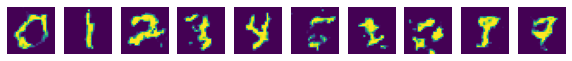

252,253,254,255,256,257,258,259,260,261,

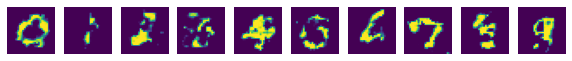

262,263,264,265,266,267,268,269,270,271,

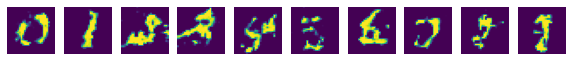

272,273,274,275,276,277,278,279,280,281,

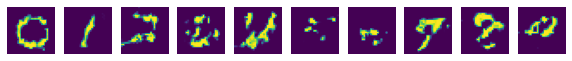

282,283,284,285,286,287,288,289,290,291,

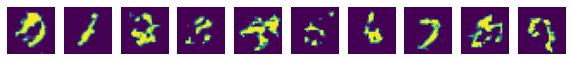

292,293,294,295,296,297,298,299,300,301,

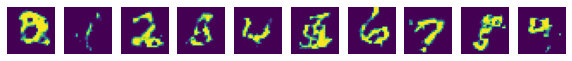

302,303,304,305,306,307,308,309,310,311,

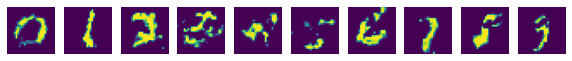

312,313,314,315,316,317,318,319,320,321,

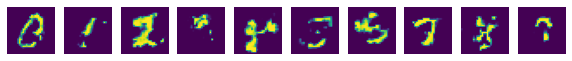

322,323,324,325,326,327,328,329,330,331,

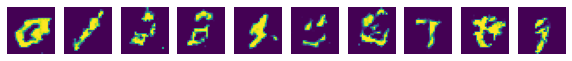

332,333,334,335,336,337,338,339,340,341,

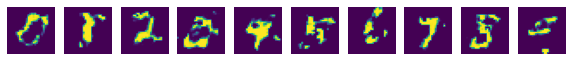

342,343,344,345,346,347,348,349,350,351,

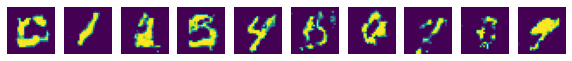

352,353,354,355,356,357,358,359,360,361,

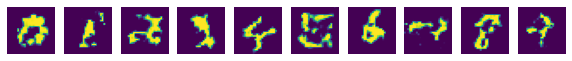

362,363,364,365,366,367,368,369,370,371,

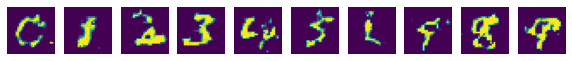

372,373,374,375,376,377,378,379,380,381,

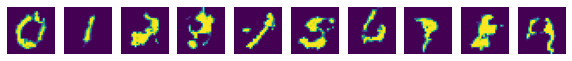

382,383,384,385,386,387,388,389,390,391,

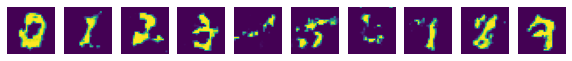

392,393,394,395,396,397,398,399,400,401,

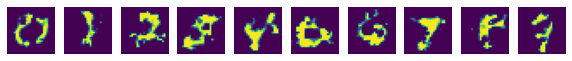

402,403,404,405,406,407,408,409,410,411,

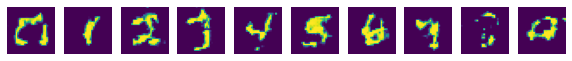

412,413,414,415,416,417,418,419,420,421,

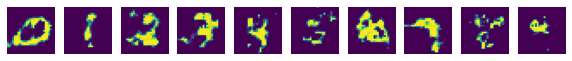

422,423,424,425,426,427,428,429,430,431,

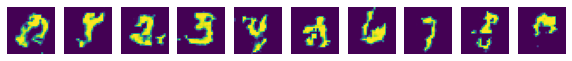

432,433,434,435,436,437,438,439,440,441,

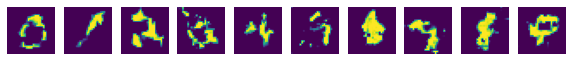

442,443,444,445,446,447,448,449,450,451,

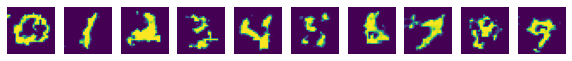

452,453,454,455,456,457,458,459,460,461,

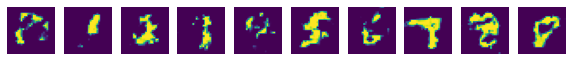

462,463,464,465,466,467,468,469,470,471,

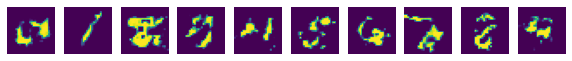

472,473,474,475,476,477,478,479,480,481,

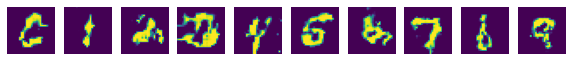

482,483,484,485,486,487,488,489,490,491,

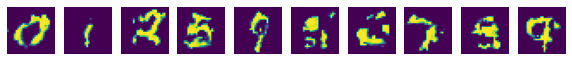

492,493,494,495,496,497,498,499,500,

In [59]:
for epoch in range(epochs):
    for image_batch,label_batch in dataset:
        train_step(image_batch,label_batch)
    print(epoch+1,end=',')
    if epoch%10==0:
        plot_img()
    

In [54]:
gen.save('acgen.h5')
disc.save('acdisc.h5')